In [27]:
# Initialize plotting:
%matplotlib inline
# Import all relevant packages
import PIL
from PIL import Image
import scipy.ndimage
import numpy as np, matplotlib.pyplot as plt
import scipy.stats
import scipy as sp
from ipywidgets import interact
from scipy.integrate import solve_ivp

from importlib import reload
from IPython.display import clear_output, display

# Suppress some logging messages in Pillow (Python Imaging Library)
import logging; logging.getLogger('PIL').setLevel(logging.ERROR)  # Suppress PIL messages


## The Problem



Given some data $d$ obtained by adding noise to an original image $u_0$, how can we best approximate $u$?  In this assignment, we will explore approximations $u_\lambda$ obtained from the minimization problem

<!-- \begin{gather} -->
$$
  \min_{u} E[u], \qquad
  \underbrace{E[u]}_{\text{energy}} = \underbrace{\int |\nabla u|^2}_{\text{regularization}} + \lambda \underbrace{\int |u-d|^2}_{\text{data fidelity}},\\
  d = u + \eta, \qquad
  \eta \sim \mathcal{N}(0, \sigma),
% \end{gather}
$$


where $\eta$ is (approximately) gaussian noise with standard deviation $\eta$.

We call $E[u]$ the "energy", and in the following, normalize it by $E[d]$ so that the noisy image has energy $E[d]=1$.



In [28]:
import denoise

sigma = 0.4
lam = 0.1
im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam)
u_exact = im.get_data(sigma=0)
u_noise = im.get_data(sigma=sigma)
u = d.minimize(callback=None)
E_u = d.get_energy(u)
E_noise = d.get_energy(u_noise)
E_exact = d.get_energy(u_exact)

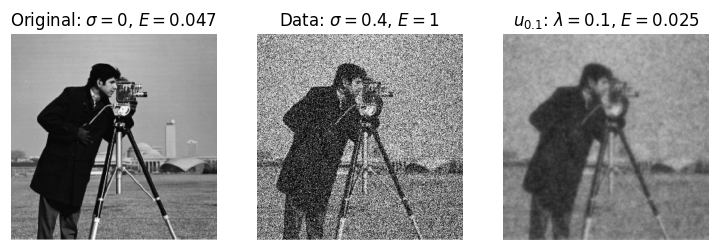

In [29]:
fig, axs = denoise.subplots(3)
for _u, title, ax in [(u_exact, rf"Original: $\sigma=0$, $E={E_exact:.2g}$", axs[0]),
                     (u_noise, rf"Data: $\sigma={sigma}$, $E={E_noise:.2g}$", axs[1]),
                     (u, rf"$u_{{{lam}}}$: $\lambda={lam}$, $E={E_u:.2g}$", axs[2])]:
    im.show(_u, ax=ax)
    ax.set(title=title);

### Loading Images

Use the [Python Imaging Library](https://python-pillow.org/) (PIL) to load images:

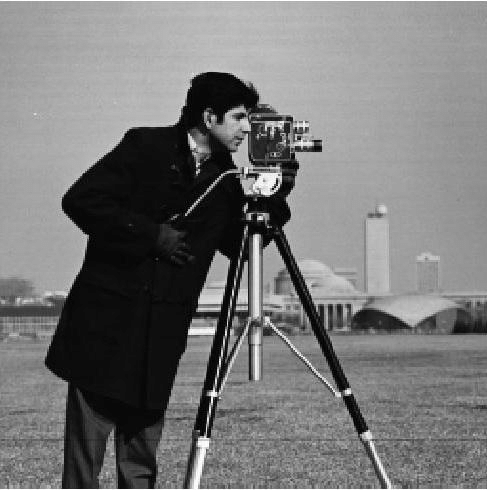

In [46]:

im = Image.open("images/The-original-cameraman-image.png")
im  # or display(im), but this happens by default for the last line

### Adding Noise

In [48]:
# First, see what the data looks like as an array.
# We also normalize pixel values in [0, 1)
u = u_exact = np.asarray(im.convert("L")) / 256
display(u)
display((u.shape, u.max(), u.min()))
print(f"{u.shape=}, {u.max()=}, {u.min()=}")  # Nicer python f-string

array([[0.97265625, 0.98046875, 0.98046875, ..., 0.98828125, 0.98046875,
        0.98828125],
       [0.62109375, 0.62109375, 0.62890625, ..., 0.59765625, 0.60546875,
        0.60546875],
       [0.61328125, 0.61328125, 0.61328125, ..., 0.59765625, 0.59765625,
        0.57421875],
       ...,
       [0.4765625 , 0.4921875 , 0.50390625, ..., 0.51171875, 0.51171875,
        0.4296875 ],
       [0.50390625, 0.50390625, 0.4921875 , ..., 0.51171875, 0.50390625,
        0.4140625 ],
       [0.95703125, 0.98046875, 0.98828125, ..., 0.97265625, 0.99609375,
        0.95703125]])

((490, 487), 0.99609375, 0.0)

u.shape=(490, 487), u.max()=0.99609375, u.min()=0.0


We see that the image is 490×487 in shape, and has unsigned integers ranging from 0 to 255.

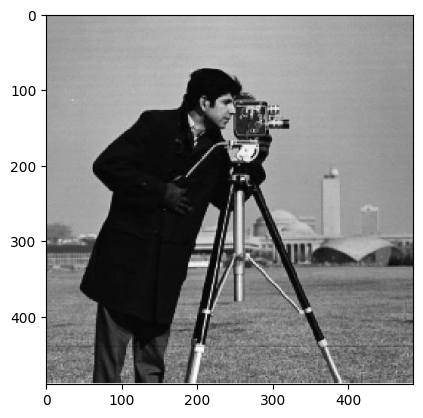

In [49]:
# We can also display the array
plt.imshow(u, vmin=0, vmax=1, cmap="gray", interpolation=None)

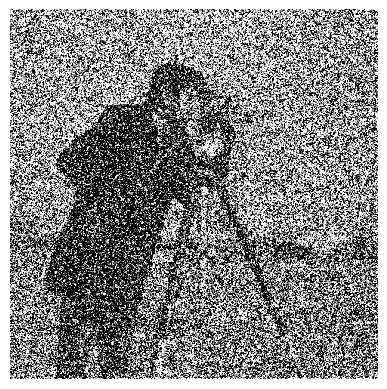

In [50]:
# Use random numbers to add noise.  Here we get a random number generator (rng)
# and use a fixed seed so we can reproduce our results
rng = np.random.default_rng(seed=2)
sigma = 1
u_noise = u + sigma * rng.normal(size=u.shape)
plt.imshow(u_noise, vmin=0, vmax=1, cmap="gray")

# Turn off the axes
ax = plt.gca()
ax.axis("off");

### Removing Noise

In [51]:
def imshow(u):
    fig, ax = plt.subplots()
    im = ax.imshow(u, vmin=0, vmax=1, cmap='gray')
    return im

In [52]:
def laplacian(u):
    """Return the laplacian of the image usings unit spacing."""
    return sum(
        np.gradient(
            np.gradient(u, axis=_a, edge_order=2), axis=_a, edge_order=2)
        for _a in [0, 1])
    return (np.gradient(np.gradient(u, axis=0), axis=0) +
            np.gradient(np.gradient(u, axis=1), axis=1))

# This already exists, with better boundary condistion, in scipy:
def laplacian(u):
    return sp.ndimage.laplace(u)

In [53]:
d2u = laplacian(u_exact)

@interact(p=(0, 50, 1))
def go(p=10):
    "Explore percentile thresholding of laplacian"
    fig, axs = plt.subplots(1, 2)
    for ax, u in zip(axs, [u_exact, u_noise]):
        d2u = laplacian(u)
        vmin, vmax = np.percentile(d2u, [p, 100-p])
        ax.imshow(d2u, vmin=vmin, vmax=vmax, cmap='gray')
        ax.axis("off")

interactive(children=(IntSlider(value=10, description='p', max=50), Output()), _dom_classes=('widget-interact'…

Minimize

\begin{gather}
  f(y) = E[u] = \int\abs{\vect{\nabla} u}^2 + \lambda \int \abs{u - d}^2,\\
  f'(y) = dE(u) = \frac{\partial E}{\partial{u}} = 2\Bigl(-\nabla^2u + \lambda (u-d)\Bigr) = 0,
\end{gather}
where $d\equiv$`u_noise` is the **data**, or the noisy image. We can do this with a
direct gradient descent:

\begin{gather}
  \frac{d u}{d t} = -\beta\; dE(u)
\end{gather}

mIb/9hg0b2FpjNBpx5swZHDhwACUlJXA4HHj55Zexfv165OXlYcGCBQgODsb333+PwsJChIeH409/+hMMBgNHDhcUFCA3NxcbN27Evn37cPvttyMoKAjZ2dmoqKjAnXfeyUAiQgv39vYyBMdsNmNubg6HDx9mq+Ds7CwWLlyIefPmcdqYy+VCbGwstmzZgqCgIAZ+ZGVlISsrC3K5HHa7nb+XO+64A2vXroVCoYBMJkN6ejp3WGSDrK+vZ1jTli1bsGrVKnz88cf4/e9/j4KCgvO9XX9TFzUJdD9SPC7dHzExMWhvb4dcLuegH4fDwfkFLpeLD2iKSSd4EKm6U1JSuCMnxwABWYxGI2tdLBYLJicneZpDDiiHwwGNRsPCMUKXu1wuhIeHQ6/Xo7u7+5y8Ao/Hg6amJgD/FLRSx09fIzg4GCaTidG9BL4i6x7tvQUCAVMzo6OjMTo6ypPCxMREdHd38zrF6XSip6eH99Deqark3KDnkcVigU6n4/12RkYGxsbGmAbpDdqxWCwsrqbDc3Z2FtHR0QgJCcHg4CBUKhUXJfHx8RCLxYiKiuIoaOq8KYCKRuREKyUxI4lFw8PDAYChUhMTE0xCpNeEoobXrFmD0tJSJCQkoLOzE7W1tZxQSLoeWgF54+UbGxt5AmK1WjE9PY3U1FSEh4cjNDSUNRIkHO7p6YGfnx/6+vr44KXcCnoOAmetwPQ5GRsbQ1RUFBQKBaampvgz4p2YSJOxubk5DumKi4uDTCaDRqOBVquF1WpFWVkZfyaHhoYwPj6O9vZ2JCQkoLa2FmazmT/blGQplUohk8k4EIoKqZGREbS1tfH6+Neu8y4GoqOjObxCqVTyboWsYadPn4bJZMIHH3yAvr4+tLa2cpcZERHBiWUKhQIhISGIjo7m9L7q6mqGP9DhTRQ5UpnSCoD2aw6HA1lZWRz/KRKJUF1dzRMGGkfSXot2OOQCoIsqePJ9UrVI/01jHBLCUUVGOGSqIkn

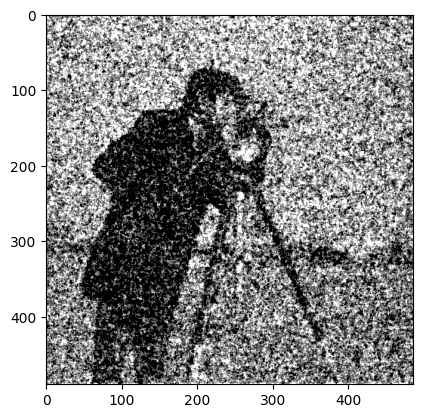

In [54]:
beta = 1.0
lam = 1.0  # Lam

def compute_E(u, lam=lam):
    """Return the energy."""
    E_regularization = (-u * laplacian(u)).sum()
    E_data_fidelity = (np.abs(u-u_noise)**2).sum()
    print(f"{E_regularization=}, {E_data_fidelity=}")
    return E_regularization + lam * E_data_fidelity

def compute_dy_dt(t, y, beta=beta, lam=lam):
    """Return dy_dt."""
    # solve_ivp expects y to be 1D, so we need to reshape
    u = y.reshape(u_noise.shape)
    du = 2*(-laplacian(u) + lam * (u - u_noise))
    dy = np.ravel(- beta * du)
    return dy


# Make initial guess 1D.  We start with the noise.
y0 = np.ravel(u_noise)
dT = 10
res = solve_ivp(compute_dy_dt, y0=y0, t_span=(0, dT))
u1 = res.y[:, -1].reshape(u_noise.shape)
plt.imshow(u1, vmin=0, vmax=1, cmap='gray')

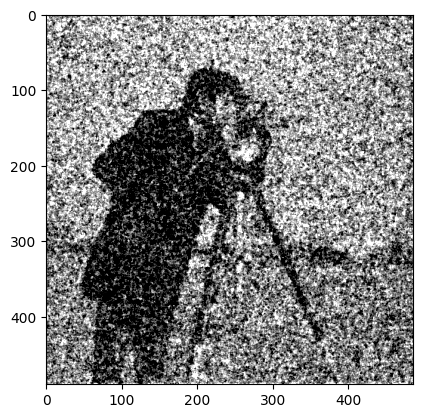

100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


In [55]:
from scipy.integrate import solve_ivp
from functools import partial
from IPython.display import clear_output
import tqdm

dT = 1
lam = 1  # Lam

steps = 10

err0 = (np.abs(u_noise - u_exact)**2).mean()
E0 = compute_E(u_noise, lam=lam)

errs = []
Es = []
ts = []
y = y0
t = 0
fig, ax = plt.subplots()
for step in tqdm.tqdm(range(steps)):
    res = solve_ivp(partial(compute_dy_dt, beta=beta, lam=lam), y0=y, t_span=(t, t+dT))
    y = res.y[:, -1]
    u = y.reshape(u_noise.shape)
    errs.append((np.abs(u - u_exact)**2).mean())#/err0)
    Es.append(compute_E(u, lam=lam)/E0)
    t = res.t[-1]
    ts.append(t)
    ax.cla()
    ax.imshow(u, vmin=0, vmax=1, cmap='gray')
    clear_output(wait=True)
    display(fig)
plt.close('all')

0.09192442043304534

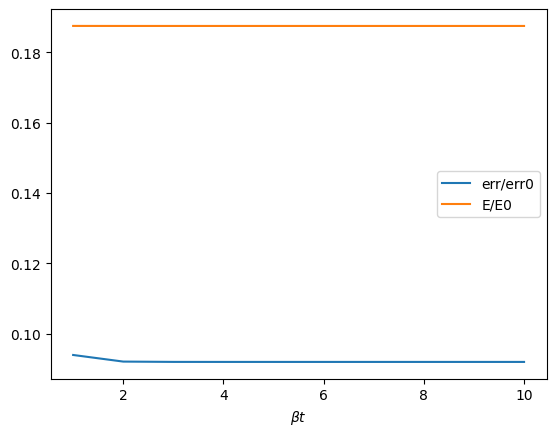

In [56]:
fig, ax = plt.subplots()
ax.plot(ts, errs, label='err/err0')
ax.plot(ts, Es, label='E/E0')
ax.legend()
ax.set(xlabel=r"$\beta t$");  # Python r-string
np.amin(errs)

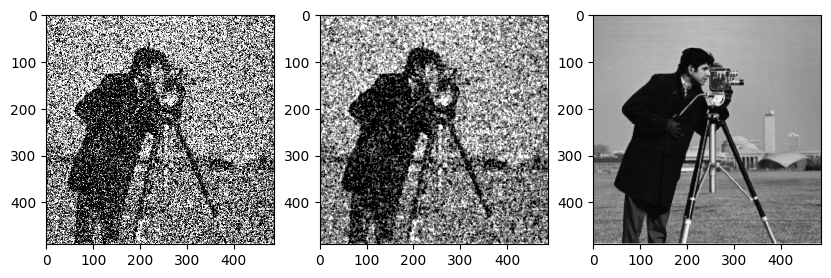

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
ax = axs[0]
ax.imshow(u_noise, vmin=0, vmax=1, cmap="gray")
ax = axs[1]
ax.imshow(u, vmin=0, vmax=1, cmap="gray")
ax = axs[2]
ax.imshow(u_exact, vmin=0, vmax=1, cmap="gray")

## Exploration

Here we explore some properties of denoising using the tools in `denoise.py`, which
packages code similar to that use above into classes and functions for easy reuse,
testing, and exploration.

We start with an image and various levels of noise.  Here we normalize the images to have values between $0$ (black) and $1$ (white).  The noise is normally distribute $\eta \sim \mathcal{N(0, \sigma)}$ with standard deviation $\sigma$ with values truncated so that the pixel values remain between $0$ and $1$, so the resulting noise is not exactly gaussian, but is truncated in a way that depends on the value of the pixels in the image.



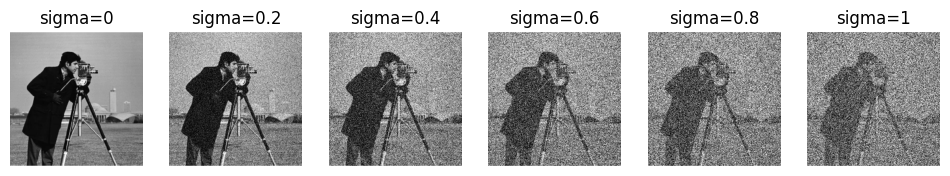

In [58]:
import denoise;reload(denoise)

im = denoise.Image()
sigmas = np.linspace(0, 1, 6)
fig, axs = plt.subplots(1, len(sigmas), figsize=(len(sigmas)*2, 2))
for sigma, ax in zip(sigmas, axs):
    plt.sca(ax)
    im.imshow(im.get_data(sigma=sigma))
    ax.set(title=f"{sigma=:.2g}")

If we did not truncate the pixel values to remain in $[0, 1]$, then the following image of the noise term would be completely random.  The truncation leaves an imprint of the image for large values of $\sigma$:

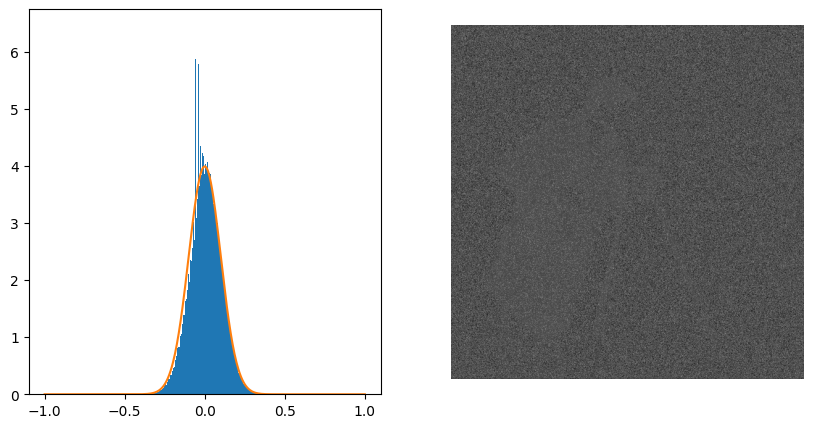

In [59]:
sigma = 0.1
fig, axs = denoise.subplots(2, height=5)
im = denoise.Image()
u_exact = im.get_data(sigma=0)
u_noise = im.get_data(sigma=sigma)
du = u_noise - u_exact
im.show(du, ax=axs[1])
ax = axs[0]
ax.hist(du.ravel(), bins=200, density=True);
x = np.linspace(-1, 1, 500)
ax.plot(x, sp.stats.norm(scale=sigma).pdf(x))

Now we try denoising $\sigma=0.4$ with various values of $\lambda$:

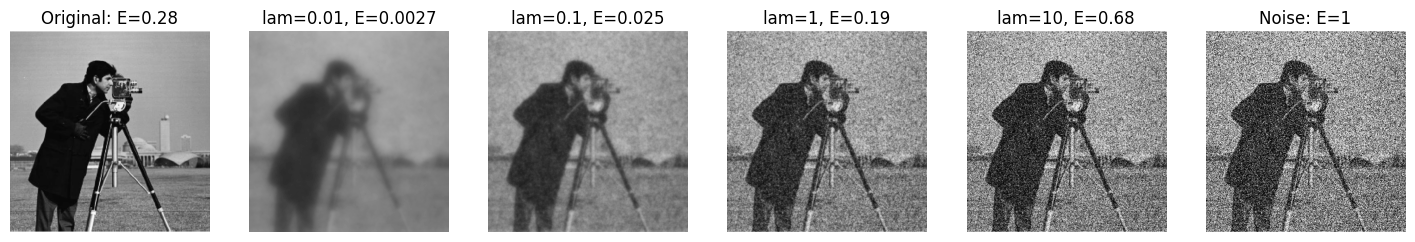

In [60]:
import denoise;reload(denoise)

sigma = 0.4
lams = [0.01, 0.1, 1, 10]
im = denoise.Image()
d = denoise.Denoise(image=im)

fig, axs = denoise.subplots(2+len(lams), height=3)

for label, u, ax in [("Original", d.u_exact, axs[0]),
                     ("Noise", d.u_noise, axs[-1])]:
    im.show(u, ax=ax)
    ax.set(title=f"{label}: E={d.get_energy(u):.2g}")

display(fig)
for lam, ax in zip(lams, axs[1:-1]):
    d = denoise.Denoise(image=im, sigma=sigma, lam=lam)
    u = d.minimize(callback=True, plot=False)
    im.show(u, ax=ax)
    ax.set(title=f"{lam=:.2g}, E={d.get_energy(u):.2g}")
    clear_output(wait=True)
    display(fig)
plt.close('all')